In [484]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from time import perf_counter
import cProfile
import random


In [485]:
# Data Generation
np.random.seed(42)
x = np.random.rand(13500000*15, 1)
y = 1 + 2 * x + .1 * np.random.randn(13500000*15, 1)
print(len(x))
print(x)

# Shuffles the indices
idx = np.arange(13500000*15)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:]
# Uses the remaining indices for validation
#val_idx = idx[500000000:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
#x_val, y_val = x[val_idx], y[val_idx]

print(x_train)


202500000
[[0.37454012]
 [0.95071431]
 [0.73199394]
 ...
 [0.03365269]
 [0.32790563]
 [0.80735113]]
[[0.26726292]
 [0.01922887]
 [0.80931828]
 ...
 [0.49762245]
 [0.69895611]
 [0.21513802]]


In [486]:
%%time
# Simple regression problem: 
# y = a + bx + e
# Initializes parameters "a" and "b" randomly
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)
print(a,b)

# Sets learning rate
lr = 0.5

# Defines number of iterations
n_epochs = 1000

# Defines minibatch step size
minibatch_size=50

#start = perf_counter()

for epoch in range(n_epochs):
    sampling = random.choices(np.arange(len(x_train)), k=minibatch_size)
    x_batch = x_train[sampling]
    y_batch = y_train[sampling]
        
    # Computes our model's predicted output
    yhat = a + b * x_batch
    
    # How wrong is our model? That's the error! 
    error = (y_batch - yhat)
    
    # It is a regression, so it computes mean squared error (MSE)
    #loss = (error ** 2).mean()
    loss = (error ** 2).mean()


    # Computes gradients for both "a" and "b" parameters
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_batch * error).mean()

    # Updates parameters using gradients and the learning rate
    a = a - lr * a_grad
    b = b - lr * b_grad

print(a,b)


[0.49671415] [-0.1382643]
[0.98914178] [2.02052165]
Wall time: 6min 23s


<function matplotlib.pyplot.show(*args, **kw)>

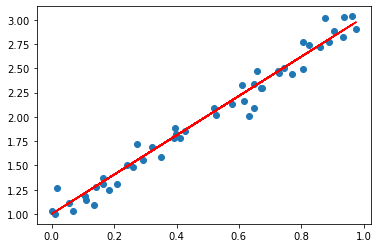

In [487]:
#plot linear regression
plt.figure(3) 
plt.scatter(x_batch,y_batch)
plt.plot(x_batch,yhat,color = 'red')
plt.show


In [488]:
# Sanity Check: do we get the same results as our gradient descent?
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_batch, y_batch)
print(linr.intercept_, linr.coef_[0])

[0.97498248] [2.05249904]


In [489]:
import torch

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train = np.unique(x_train)
y_train = np.unique(y_train)
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.cuda.FloatTensor


In [490]:
#parameters initialization with PyTorch 

torch.manual_seed(42)
a = torch.cuda.FloatTensor(1).normal_()
b = torch.cuda.FloatTensor(1).normal_()
print(a,b)


tensor([0.1940], device='cuda:0') tensor([0.1391], device='cuda:0')


In [491]:
%time
lr = 0.01
n_epochs = 1000

start = perf_counter()

with torch.autograd.profiler.profile(use_cuda=True) as prof:


    for epoch in range(n_epochs):


        sampling = random.choices(np.arange(len(x_train_tensor)), k=minibatch_size)

        x_batch_tensor = x_train_tensor[sampling]
        y_batch_tensor = y_train_tensor[sampling]
        # mandare i batch calcolati alla gpu 
        #x_batch_tensor.to(device)
        #y_batch_tensor.to(device)


        yhat_tensor = a + b * x_batch_tensor
        error = y_batch_tensor - yhat_tensor
        loss = (error ** 2).mean()


        a_grad_tensor = -2 * error.mean()
        b_grad_tensor = -2 * (x_batch_tensor * error).mean()

        # Updates parameters using gradients and the learning rate
        a = a - lr * a_grad_tensor
        b = b - lr * b_grad_tensor

print(prof.key_averages().table(sort_by="self_cpu_time_total"))    
print(a, b)


Wall time: 0 ns
---------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
Name       Self CPU total %  Self CPU total   CPU total %      CPU total        CPU time avg     CUDA total %     CUDA total       CUDA time avg    Number of Calls  
---------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
to         25.22%           312.898ms        31.95%           396.325ms        99.081us         0.09%            347.123ms        86.781us         4000             
mul        22.76%           282.363ms        22.76%           282.363ms        47.060us         0.12%            479.964ms        79.994us         6000             
index      12.51%           155.196ms        12.51%           155.196ms        77.598us         0.06%            222.582ms        111.291us        2000       

<function matplotlib.pyplot.show(*args, **kw)>

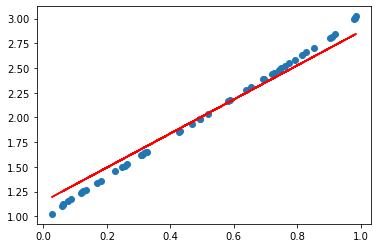

In [481]:
#plot linear regression
plt.figure(4) 
x_batch_tensor = torch.Tensor.cpu(x_batch_tensor)
y_batch_tensor = torch.Tensor.cpu(y_batch_tensor)
yhat_tensor = torch.Tensor.cpu(yhat_tensor)

plt.scatter(x_batch_tensor,y_batch_tensor)
plt.plot(x_batch_tensor,yhat_tensor,color = 'red')
plt.show
